<a href="https://colab.research.google.com/github/Abrhm-ma25/Text-classification-algorithm/blob/main/ft_transformers_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#########################################################################
# 1. Setup and Imports
#########################################################################

# --- Core utilities ---
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display

# Silence irrelevant warnings
warnings.filterwarnings("ignore")

# --- Disable Weights & Biases fully ---
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_SILENT"] = "true"

# --- Hugging Face libraries ---
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# --- Metrics ---
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- Device & batch size ---
if torch.cuda.is_available():
    device = "cuda"
    BATCH_SIZE = 16
else:
    device = "cpu"
    BATCH_SIZE = 8

print(f"✅ Device detected: {device}")
print(f"📦 Batch size per device: {BATCH_SIZE}")
print(f"🧠 PyTorch version: {torch.__version__}")

✅ Device detected: cuda
📦 Batch size per device: 16
🧠 PyTorch version: 2.9.0+cu126


In [3]:
#########################################################################
# 2. Load and Explore the Dataset
#########################################################################

train_df = pd.read_csv(
    "https://raw.githubusercontent.com/Abrhm-ma25/Text-classification-algorithm/refs/heads/main/Datasets/step1-2_cleaned_data.csv"
)
val_df = pd.read_csv(
    "https://raw.githubusercontent.com/Abrhm-ma25/Text-classification-algorithm/refs/heads/main/Datasets/step1-2_cleaned_validation.csv"
)

print(f"✅ Training data shape: {train_df.shape}")
print(f"✅ Validation data shape: {val_df.shape}")
print("Training sentiment distribution:")
print(train_df["sentiment"].value_counts())


# Preview
print("\n🔹 Training set preview:")
display(train_df.head())

print("\n🔹 Validation set preview:")
display(val_df.head())

✅ Training data shape: (50371, 4)
✅ Validation data shape: (706, 4)
Training sentiment distribution:
sentiment
Positive    18548
Negative    16345
Neutral     15478
Name: count, dtype: int64

🔹 Training set preview:


,id,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...



🔹 Validation set preview:


,id,topic,sentiment,tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
2,4433,Google,Neutral,Now the President is slapping Americans in the...
3,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
4,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \r\n\r\nNew TE Austin...



📊 Sentiment Distribution — Training Set


,Count,Percentage (%)
sentiment,,
Positive,18548,36.82
Negative,16345,32.45
Neutral,15478,30.73


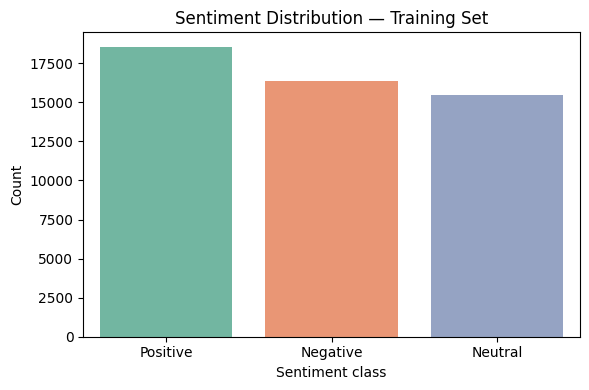


📊 Sentiment Distribution — Validation Set


,Count,Percentage (%)
sentiment,,
Neutral,257,36.40
Positive,255,36.12
Negative,194,27.48


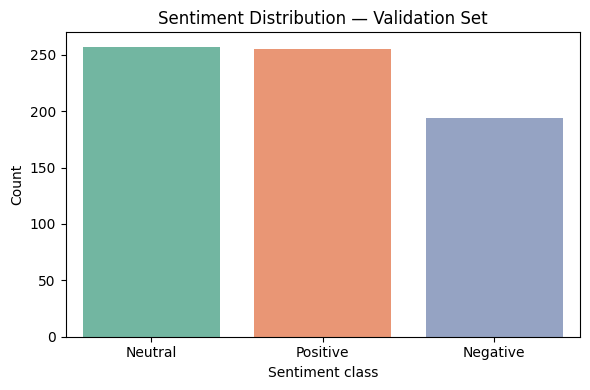

Both the training and validation sets show a reasonably balanced distribution 
across the three sentiment classes — around 30% for each (approximately 1/3 each). 
This balanced distribution helps ensure reliable fine-tuning 
for both encoder-only and encoder–decoder models. 


In [10]:
# Check class distribution

def show_class_distribution(df, name):
    counts = df["sentiment"].value_counts()
    percentages = (counts / len(df) * 100).round(2)

    print(f"\n📊 Sentiment Distribution — {name}")
    display(pd.DataFrame({
        "Count": counts,
        "Percentage (%)": percentages
    }))

    # Plot
    plt.figure(figsize=(6,4))
    sns.countplot(
        x="sentiment",
        data=df,
        order=counts.index,
        palette="Set2"
    )
    plt.title(f"Sentiment Distribution — {name}")
    plt.ylabel("Count")
    plt.xlabel("Sentiment class")
    plt.tight_layout()
    plt.show()

# Show distributions
show_class_distribution(train_df, "Training Set")
show_class_distribution(val_df, "Validation Set")

print(
    """Both the training and validation sets show a reasonably balanced distribution
across the three sentiment classes — around 30% for each (approximately 1/3 each).
This balanced distribution helps ensure reliable fine-tuning
for both encoder-only and encoder–decoder models. """)


In [4]:
#########################################################################
# 3. Preprocessing
#########################################################################

# 1️⃣ Rename columns for consistency
train_df = train_df.rename(columns={"tweet": "text", "sentiment": "Sentiment"})
val_df   = val_df.rename(columns={"tweet": "text", "sentiment": "Sentiment"})

# 2️⃣ Map 3 sentiment classes to numeric labels
label_map = {label: i for i, label in enumerate(sorted(train_df["Sentiment"].unique()))}
train_df["label"] = train_df["Sentiment"].map(label_map)
val_df["label"]   = val_df["Sentiment"].map(label_map)

print("✅ Label mapping:", label_map)
print("✅ Sentiments present:", train_df["Sentiment"].unique())

train_df_model = train_df[["text", "label"]].reset_index(drop=True)
val_df_model   = val_df[["text", "label"]].reset_index(drop=True)

print("\nTrain (model) head:")
display(train_df_model.head())

print("\nVal (model) head:")
display(val_df_model.head())

# 3️⃣ Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_model)
val_dataset   = Dataset.from_pandas(val_df_model)


✅ Label mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
✅ Sentiments present: ['Positive' 'Neutral' 'Negative']

Train (model) head:


,text,label
0,I am coming to the borders and I will kill you...,2
1,im getting on borderlands and i will kill you ...,2
2,im coming on borderlands and i will murder you...,2
3,im getting on borderlands 2 and i will murder ...,2
4,im getting into borderlands and i can murder y...,2



Val (model) head:


,text,label
0,"CSGO matchmaking is so full of closet hacking,...",0
1,Now the President is slapping Americans in the...,1
2,Hi @EAHelp I’ve had Madeleine McCann in my cel...,0
3,Thank you @EAMaddenNFL!! \r\n\r\nNew TE Austin...,2
4,"Rocket League, Sea of Thieves or Rainbow Six: ...",2


In [5]:
# ============================================================
# 4. Utility: Freeze last N transformer layers (for encoder models)
# ============================================================

def freeze_transformer_layers(model, n_unfrozen: int = 2):
    """
    Freeze all base transformer layers except the last `n_unfrozen` encoder layers.
    Works for models that follow the `base_model_prefix` convention (e.g., roberta).
    """
    if not hasattr(model, "base_model_prefix"):
        print("⚠️ Model has no base_model_prefix. Skipping freezing.")
        return

    base = getattr(model, model.base_model_prefix, None)
    if base is None:
        print("⚠️ Could not access base model. Skipping freezing.")
        return

    encoder = getattr(base, "encoder", None)
    if encoder is None or not hasattr(encoder, "layer"):
        print("⚠️ Could not access encoder layers. Skipping freezing.")
        return

    # 1) Freeze all base parameters
    for param in base.parameters():
        param.requires_grad = False

    # 2) Unfreeze last n layers
    if n_unfrozen > 0:
        for layer in encoder.layer[-n_unfrozen:]:
            for param in layer.parameters():
                param.requires_grad = True

    # 3) Always train the classification head
    if hasattr(model, "classifier"):
        for param in model.classifier.parameters():
            param.requires_grad = True

    print(f"✅ Frozen all base layers except last {n_unfrozen} transformer layers.")


In [6]:
# ============================================================
# 5. Fine-tuning function: Encoder-only models (RoBERTa)
# ============================================================

def train_and_evaluate_encoder(model_name: str, num_train_epochs: int = 3):
    """
    Fine-tune encoder-only models (RoBERTa) on sentiment classification.
    Uses:
    - dynamic padding via DataCollatorWithPadding
    - early stopping
    - optional layer freezing
    """
    print(f"\n🚀 Fine-tuning (Encoder-only): {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # --- Tokenization ---
    def tokenize_fn(examples):
        texts = list(examples["text"])
        return tokenizer(
            texts,
            truncation=True,
            padding=False,  # padding handled by DataCollatorWithPadding
            max_length=128,
        )

    tokenized_train = train_dataset.map(tokenize_fn, batched=True)
    tokenized_val   = val_dataset.map(tokenize_fn, batched=True)

    # --- Model setup ---
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_map)
    ).to(device)

    # Freeze all but last 2 layers (RoBERTa) + classifier
    freeze_transformer_layers(model, n_unfrozen=2)

    # --- Metrics (accuracy, precision, recall, f1) ---
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average="weighted", zero_division=0
        )
        acc = accuracy_score(labels, preds)
        return {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    # --- Training arguments (note: eval_strategy, not evaluation_strategy) ---
    args = TrainingArguments(
        output_dir=f"./results/{model_name.split('/')[-1]}",
        eval_strategy="epoch",              # ✅ transformers 4.57
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none",
    )

    # --- Data collator for efficient padding ---
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # --- Trainer with Early Stopping ---
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()
    results = trainer.evaluate()
    return model, tokenizer, results


In [7]:
# ============================================================
# 6. Fine-tuning function: Encoder–Decoder models (T5-small)
# ============================================================

def train_and_evaluate_encoder_decoder(model_name: str, num_train_epochs: int = 3):
    """
    Fine-tune encoder-decoder models (T5) by framing sentiment as text generation.

    Input:  "tweet: <text> sentiment:"
    Target: "Positive" / "Negative" / "Neutral"
    """

    print(f"\n🚀 Fine-tuning (Encoder-Decoder): {model_name}")

    # --- Load tokenizer and model ---
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

    # --- Prepare text-to-text data ---
    id2label = {v: k for k, v in label_map.items()}
    train_df_local = train_df.copy()
    val_df_local   = val_df.copy()

    train_df_local["target_text"] = train_df_local["label"].map(id2label)
    val_df_local["target_text"]   = val_df_local["label"].map(id2label)

    train_df_local["formatted_input"] = "tweet: " + train_df_local["text"] + " sentiment:"
    val_df_local["formatted_input"]   = "tweet: " + val_df_local["text"] + " sentiment:"

    # HuggingFace Dataset
    train_dataset_t5 = Dataset.from_pandas(train_df_local[["formatted_input", "target_text"]])
    val_dataset_t5   = Dataset.from_pandas(val_df_local[["formatted_input", "target_text"]])

    # --- Tokenization for T5 (input + target) ---
    def preprocess_fn(batch):
        model_inputs = tokenizer(
            batch["formatted_input"],
            padding="max_length",
            truncation=True,
            max_length=128,
        )
        # Encode target labels
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                batch["target_text"],
                padding="max_length",
                truncation=True,
                max_length=10,
            )
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_train = train_dataset_t5.map(preprocess_fn, batched=True)
    tokenized_val   = val_dataset_t5.map(preprocess_fn, batched=True)

    # --- Training arguments ---
    args = TrainingArguments(
        output_dir=f"./results/{model_name.split('/')[-1]}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        report_to="none",  # disable W&B
    )

    # --- Trainer ---
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
    )

    # Train
    trainer.train()

    # 🔎 Full validation evaluation (Accuracy, Precision, Recall, F1)

    preds, refs = [], []

    for _, row in val_df_local.iterrows():
        prompt = "tweet: " + row["text"] + " sentiment:"
        input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.to(device)
        outputs = model.generate(input_ids, max_length=10)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        preds.append(pred)
        refs.append(row["target_text"])   # true string label

    # --- Compute metrics ---
    precision, recall, f1, _ = precision_recall_fscore_support(
        refs, preds, average="weighted", zero_division=0
    )
    acc = accuracy_score(refs, preds)

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print("\n📊 T5-small Validation Metrics:")
    print(metrics)

    return model, tokenizer, metrics


In [8]:
# ============================================================
# 7. Run Experiments
# ============================================================

models_encoder = {
    "RoBERTa-base": "roberta-base"
}

models_encoder_decoder = {
    "T5-small": "t5-small"
}

results_dict = {}
NUM_EPOCHS = 3   # ✅ shorter training as you requested

# ---------- Encoder-only (RoBERTa) ----------
for name, model_name in models_encoder.items():
    start = time.time()
    model_enc, tokenizer_enc, results = train_and_evaluate_encoder(
        model_name,
        num_train_epochs=NUM_EPOCHS
    )
    results["inference_time_sec"] = time.time() - start
    results_dict[name] = results
    print(f"\n{name} Results:", results)

# ---------- Encoder–Decoder (T5-small) ----------
for name, model_name in models_encoder_decoder.items():
    start = time.time()
    model_dec, tokenizer_dec, results = train_and_evaluate_encoder_decoder(
        model_name,
        num_train_epochs=NUM_EPOCHS
    )
    results["inference_time_sec"] = time.time() - start
    results_dict[name] = results
    print(f"\n{name} Results:", results)



🚀 Fine-tuning (Encoder-only): roberta-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/50370 [00:00<?, ? examples/s]

Map:   0%|          | 0/705 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Frozen all base layers except last 2 transformer layers.


/tmp/ipython-input-162646644.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685600,0.546171,0.780142,0.783774,0.780142,0.778705
2,0.590400,0.440526,0.809929,0.810326,0.809929,0.809430
3,0.522800,0.387194,0.839716,0.841801,0.839716,0.839363



RoBERTa-base Results: {'eval_loss': 0.38719412684440613, 'eval_accuracy': 0.8397163120567376, 'eval_precision': 0.84180064439645, 'eval_recall': 0.8397163120567376, 'eval_f1': 0.8393629146485606, 'eval_runtime': 3.5772, 'eval_samples_per_second': 197.079, 'eval_steps_per_second': 12.58, 'epoch': 3.0, 'inference_time_sec': 889.5918972492218}

🚀 Fine-tuning (Encoder-Decoder): t5-small


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/50370 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/705 [00:00<?, ? examples/s]

/tmp/ipython-input-3115006249.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.089200,0.072699
2,0.081500,0.069429
3,0.079700,0.067541


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


📏 T5-small sample accuracy on 300 examples: 0.6900

T5-small Results: {'accuracy': 0.69, 'inference_time_sec': 1324.2408864498138}


,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,inference_time_sec,accuracy
RoBERTa-base,0.387194,0.839716,0.841801,0.839716,0.839363,3.5772,197.079,12.58,3.0,889.591897,NaN
T5-small,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1324.240886,0.69


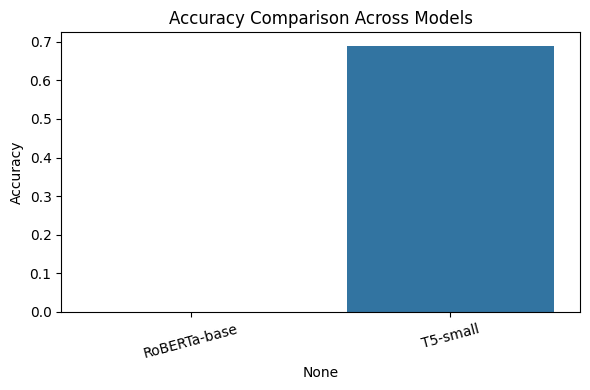

In [9]:
# ============================================================
# 8. Compare Model Performance
# ============================================================

results_df = pd.DataFrame(results_dict).T
display(results_df)

# Plot accuracy if present
if "accuracy" in results_df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x=results_df.index, y=results_df["accuracy"])
    plt.title("Accuracy Comparison Across Models")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
else:
    print("No 'accuracy' field found in results_dict to plot.")
